# Iterated Extended Kalman Smoother Solution of the 1D Wave Problem

Last Modified: Nov 15 2023<br>

Authors: Durward Cator$^1$, Simo Sarkka$^2$, Ulisses Braga-Neto$^1$ <br>
$^1$Texas A&M University<br>
$^2$Aalto University<br>
https://sciml.tamids.tamu.edu/<br>

This code demonstrates the application of iterated extended Kalman smoothers (IEKS)[1,2] to obtain a Gaussian process approximation to the solution of the classical one-dimensional wave equation:
  \begin{aligned}
  & u_{tt} - 4u_{xx} = 0 \\[0.25ex]
  & u(0,t) = u(1,t) = 0 \\[0.25ex]
  & u_t(x,0) = 0 \\[-0.5ex]
  & u(x,0) = \sin(\pi x) + \frac{1}{2} \sin (4\pi x)
  \end{aligned}
where $(x,t) \in [0,1] \times [0,1]$. This problem has an analytical solution, given by D'Alembert's Formula [3]:
\begin{aligned}
     u(x,t) = \sin(\pi x) \cos(2\pi t) + \frac{1}{2}  \sin(4\pi x) \cos(8\pi t).
\end{aligned}       
This allows us to assess the accuracy of the numerical solution.

References:

[1]  Filip Tronarp, Simo Särkkä, and Philipp Hennig (2021). "Bayesian ODE Solvers: The Maximum A Posteriori Estimate", Statistics and Computing 31(23), 2021.

[2] Filip Tronarp, Hans Kersting, Simo Särkkä, Philipp Hennig. "Probabilistic Solutions To Ordinary Differential Equations As Non-Linear Bayesian Filtering: A New Perspective", Statistics and Computing, Volume 29, pages 1297-1315, 2019.

[3] L. Evans, "Partial Differential Equations", Americal Mathematical Society, 1998.

In [ ]:
# get the necessary packages
import numpy as np
import scipy as sp
from scipy import sparse
from scipy import linalg
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", message="Ill-conditioned matrix")

In [ ]:
# Problem definition and analytical solution

T = 1.0
a = 0.0
b = 1.0

# define the initial condition
u_0 = lambda x: np.sin(np.pi * x) + 0.5 * np.sin(4.0 * np.pi * x)

# define the Dirichlet BC
u_a = u_b = 0.0

# define analytical solution
u_exact = lambda x,t: np.sin(np.pi * x) * np.cos(2.0 * np.pi * t) + 0.5 * np.sin(4.0 * np.pi * x) * np.cos(8.0 * np.pi * t)

In [ ]:
# Define IEKS model

def run_ieks(dt, dx, sig=10, nell=2, niter=10):
    # the number of spatial grid points
    J = int((b - a)/dx)
    # the number of temporal grid points
    N = int(T/dt)
    # construct the mesh in (t, x)
    x = np.linspace(a, b, J + 1)       # mesh points in space
    t = np.linspace(0, T, N + 1)       # mesh points in time

    ell = nell*dx

    A_dt = np.array([[1,dt,dt**2/2],[0,1,dt],[0,0,1]])
    Q_dt = np.array([[dt**5/20,dt**4/8,dt**3/6],[dt**4/8,dt**3/3,dt**2/2],[dt**3/6,dt**2/2,dt]])

    I_Jm1 = np.eye(J-1)
    C_Jm1 = np.zeros((J-1,J-1))
    for i in range(0,J-1):
        for j in range(0,J-1):
            C_Jm1[i,j] = sig**2 * np.exp(-(x[i+1] - x[j+1])**2 / (2*ell**2))

    A = np.kron(A_dt,I_Jm1)
    Q = np.kron(Q_dt,C_Jm1)
    H_s = np.kron(np.array([[1,0,0]]),I_Jm1)
    H_d = np.kron(np.array([[0,1,0]]),I_Jm1)
    H_t = np.kron(np.array([[0,0,1]]),I_Jm1)

    def g(x):
        u = x[:J-1]
        u_jp1 = np.concatenate( (u[1:], np.array([u_b])) )
        u_jm1 = np.concatenate( (np.array([u_a]), u[0:-1]) )
        f = -4.0 * (u_jp1 - 2.*u + u_jm1) / (dx * dx)
        du = x[2 * (J-1):]
        return du + f

    def G_x(x):
        G1 = sparse.diags((-4.0 * np.ones(J-2), 8.0 * np.ones(J-1), -4.0 * np.ones(J-2)), (-1,0,1)).toarray() / (dx**2)
        G3 = np.eye(J-1)
        G2 = np.zeros_like(G3)
        return np.concatenate((G1,G2,G3),axis=1)

    nominal = np.empty((N+1, 3 * (J-1)))

    for iter in range(niter):
        # Initialize
        m = np.zeros(3 * (J-1))
        for i in range(0, J-1):
            m[i] = u_0(x[i+1])
            m[i+J-1] = 0
            m[i+2*(J-1)] = 0

        P = linalg.block_diag( np.zeros((J-1,J-1)), np.zeros((J-1,J-1)), np.zeros((J-1,J-1)) )

        m_list = np.empty((N+1, 3 * (J-1)))
        P_list = np.empty((N+1, 3 * (J-1), 3 * (J-1)))

        m_list[0,:] = m
        P_list[0,:,:] = P

        err = 0

        for n in range(1, N + 1):
            m = A @ m
            P = A @ P @ A.T + Q

            if iter == 0:
                mn = m
            else:
                mn = nominal[n,:]
            G_val = G_x(mn)
            g_val = g(mn) + G_val @ (m - mn)

            S = G_val @ P @ G_val.T
            K = linalg.solve(S, G_val @ P).T

            m = m + K @ (-g_val)

            err = err + np.dot(g_val,g_val)

            B = np.eye(K.shape[0]) - K @ G_val
            P = B @ P @ B.T

            m_list[n,:] = m
            P_list[n,:,:] = P

        err = err / dx / N / J
        #print(f"err = {err}")

        ms_list = m_list.copy()
        Ps_list = P_list.copy()
        ms = m_list[-1,:]
        Ps = P_list[-1,:,:]

        u_PS = np.zeros((N + 1, J + 1))
        u_PS_var = np.zeros((N + 1, J + 1))

        u_PS[n,0] = u_a
        u_PS[n,-1] = u_b
        u_PS[n,1:-1] = H_s @ m

        for n in range(N,-1,-1):
            m = m_list[n,:]
            P = P_list[n,:,:]

            mp = A @ m
            Pp = A @ P @ A.T + Q

            Gk = linalg.solve(Pp, A @ P).T
            ms = m + Gk @ (ms - mp)
            Ps = P + Gk @ (Ps - Pp) @ Gk.T

            ms_list[n,:] = ms
            Ps_list[n,:,:] = Ps

            u_PS[n,0] = u_a
            u_PS[n,-1] = u_b
            u_PS[n,1:-1] = H_s @ ms

            u_PS_var[n,0] = 0
            u_PS_var[n,-1] = 0
            u_PS_var[n,1:-1] = np.diag(H_s @ Ps @ H_s.T)

        if iter == 0:
            nominal = ms_list.copy()
        else:
            c = 0.1
            nominal = (1 - c) * nominal + c * ms_list

    return t, x, u_PS, u_PS_var



dt = 0.01, dx = 0.05


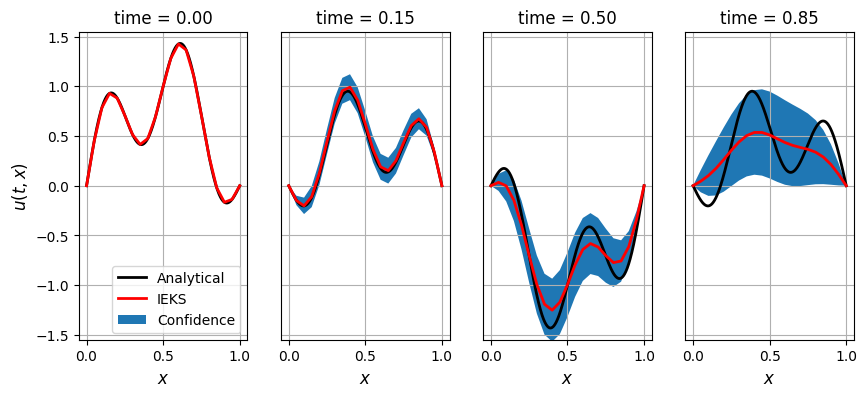

L2 error: 2.6445e-01

dt = 0.001, dx = 0.05


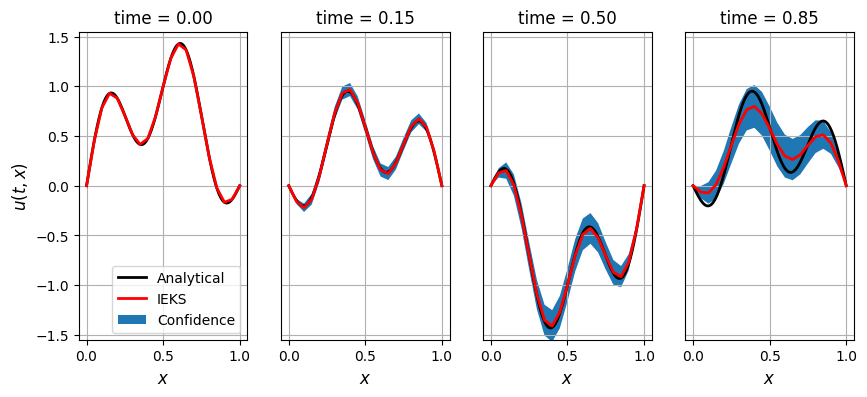

L2 error: 1.3226e-01

dt = 0.01, dx = 0.01


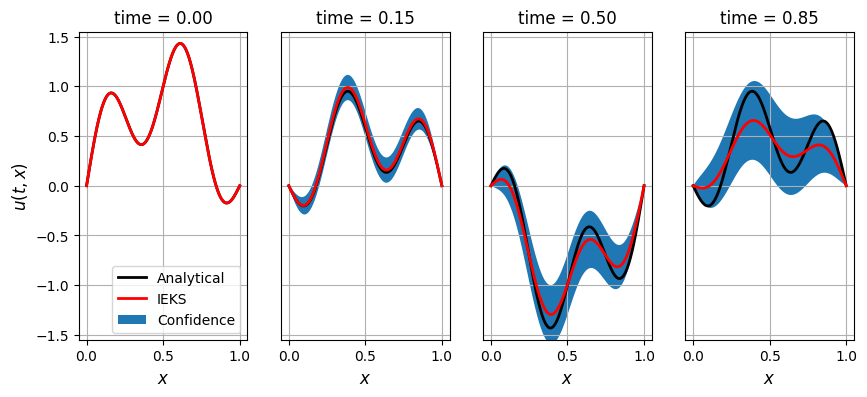

L2 error: 1.7877e-01

dt = 0.001, dx = 0.01


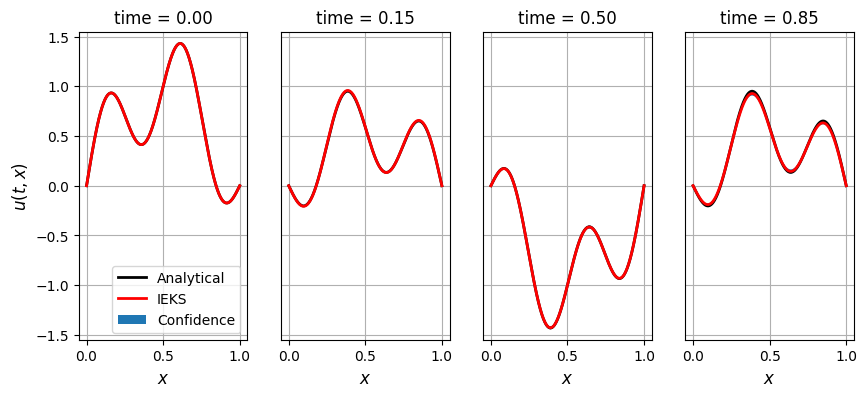

L2 error: 1.8123e-02



In [ ]:
# Run with different mesh granularities

ps_dx = [0.05, 0.05, 0.01, 0.01]
ps_dt = [0.01, 0.001, 0.01, 0.001]
sigs = [1e3, 5e3, 2e3, 1e3]

ts = []
xs = []
means = []
vars = []

for i in range(len(ps_dx)):
  ps_frames = [0, int(0.15*T/ps_dt[i]), int(0.5*T/ps_dt[i]), int(0.85*T/ps_dt[i])]

  print(f"dt = {ps_dt[i]}, dx = {ps_dx[i]}")

  ps_t, ps_x, u_PS, u_PS_var = run_ieks(ps_dt[i], ps_dx[i], sigs[i], 2, 1)
  ts.append(ps_t)
  xs.append(ps_x)
  means.append(u_PS)
  vars.append(u_PS_var)

  # choose the time (frame idx) at which the output is made
  # show the side-by-side comparison at different times
  fig = plt.figure(figsize = (10, 4))
  for idx, frame_idx in enumerate(ps_frames):
      ax = fig.add_subplot(1, 4, idx + 1)
      ax.plot(np.linspace(a,b,1000), u_exact(np.linspace(a,b,1000),frame_idx*ps_dt[i]), 'k-', linewidth = 2.0, label = 'Analytical')
      ax.plot(ps_x, u_PS[frame_idx, :], 'r-', linewidth = 2.0, label = 'IEKS')
      ax.fill_between(ps_x, u_PS[frame_idx, :] - 1.96 * np.sqrt(u_PS_var[frame_idx, :]), u_PS[frame_idx, :] + 1.96 * np.sqrt(u_PS_var[frame_idx, :]), label = 'Confidence')
      ax.grid()
      ax.set_xlabel('$x$', fontsize = 'large')
      ax.set_ylim(-1.55,1.55)
      if (idx == 0):
        ax.set_ylabel('$u(t,x)$', fontsize = 'large')
        ax.legend(loc = 'lower right')
      else:
        ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
      ax.set_title(r'time = {:.2f}'.format(ps_t[frame_idx]), fontsize = 'large')
  plt.show()

  # L2 error of IEKS means
  u_ex = np.zeros((len(ps_t),len(ps_x)))
  for i in range(len(ps_t)):
    u_ex[i] = u_exact(ps_x,ps_t[i])
  err = np.linalg.norm(u_PS-u_ex,2)/np.linalg.norm(u_ex,2)
  print('L2 error: %.4e\n' % (err))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

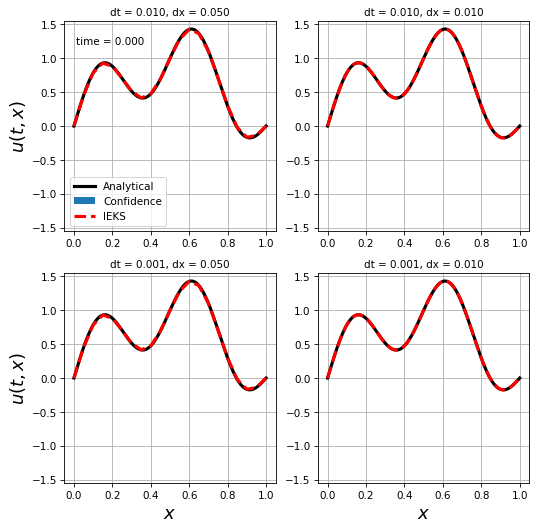

In [ ]:
# Generate time evolution video

from google.colab import files
import matplotlib.animation as animation

ps_dt_min = min(ps_dt)
time_steps = int(1./ps_dt_min) # total number of time steps in animation
fps = int(1./ps_dt_min)/10 # frames/second of animation
t_scale = np.ones(len(ts))
for i in range(len(ts)):
  t_scale[i] = time_steps/(len(ts[i])-1)

def snapshot(i):
  for j in range(len(ts)):
    idx1 = j % 2
    idx2 = int(np.floor(j / 2))
    axs[idx1, idx2].cla()
    axs[idx1, idx2].set_ylim([-1.55,1.55])
    axs[idx1, idx2].plot(np.linspace(a,b,1000), u_exact(np.linspace(a,b,1000),ts[j][int(np.floor(i/t_scale[j]))]),'k-',linewidth=3,label='Analytical')
    axs[idx1, idx2].fill_between(xs[j], means[j][int(np.floor(i/t_scale[j]))] - 1.96 * np.sqrt(vars[j][int(np.floor(i/t_scale[j]))]), means[j][int(np.floor(i/t_scale[j]))] + 1.96 * np.sqrt(vars[j][int(np.floor(i/t_scale[j]))]), label = 'Confidence')
    axs[idx1, idx2].plot(xs[j], means[j][int(np.floor(i/t_scale[j]))],'r--',linewidth=3,label='IEKS')
    #locs,labels = plt.xticks()
    axs[idx1, idx2].grid()
    axs[idx1, idx2].set_title(r'dt = {:.3f}, '.format(ps_dt[j]) + r'dx = {:.3f}'.format(ps_dx[j]),fontsize=10)
    if j == 0:
      axs[idx1, idx2].set_ylabel('$u(t,x)$',fontsize='xx-large')
      axs[idx1, idx2].text(0.01,1.2,r'time = {:.3f}'.format(i*T/((1./ps_dt_min)-1)),fontsize=10)
      axs[idx1, idx2].legend(loc='lower left')
    elif j == 1:
      axs[idx1, idx2].set_ylabel('$u(t,x)$',fontsize='xx-large')
      axs[idx1, idx2].set_xlabel('$x$',fontsize='xx-large')
    elif j == 3:
      axs[idx1, idx2].set_xlabel('$x$',fontsize='xx-large')

fig, axs = plt.subplots(2,2,figsize=(8,8),dpi=75)
anim = animation.FuncAnimation(fig,snapshot,frames=time_steps)
anim.save('Wave_IEKS_Demo.mp4',fps=fps) # Save the animation as an mp4. This requires ffmpeg to be installed.
files.download('Wave_IEKS_Demo.mp4')